In [2]:
import pandas as pd

# Load your dataset
df = pd.read_csv(r"D:\DATASCIENCE AND AI\ANALYTICS\internship\mark 5\cleaned dataset full\cleaned_mapped_employee_data.csv")  # Replace with your actual file path if needed

# Display rows where DOB or Age is missing
missing_dob_age = df[df['DOB'].isna() | df['Age'].isna()]

# Show summary
print("🔍 Number of missing values:")
print("DOB missing:", df['DOB'].isna().sum())
print("Age missing:", df['Age'].isna().sum())

# Display the first few rows with missing DOB or Age
print("\n📋 Sample rows with missing DOB or Age:")
print(missing_dob_age[['EmpID', 'DOB', 'Age', 'SeniorityLevel', 'JobFamily']].head(10))


🔍 Number of missing values:
DOB missing: 1823
Age missing: 1823

📋 Sample rows with missing DOB or Age:
    EmpID  DOB  Age SeniorityLevel   JobFamily
1    3428  NaN  NaN          Entry  Production
4    3431  NaN  NaN        Manager       Sales
8    3435  NaN  NaN        Manager       Sales
10   3437  NaN  NaN        Manager       Sales
12   3439  NaN  NaN        Manager       Sales
14   3441  NaN  NaN        Manager       Sales
15   3442  NaN  NaN        Manager       Sales
17   3444  NaN  NaN        Manager       Sales
20   3447  NaN  NaN        Manager       Sales
22   3449  NaN  NaN        Manager       Sales


In [3]:
import pandas as pd

# Filter missing rows
missing_df = df[df['DOB'].isna() | df['Age'].isna()]

# Group by SeniorityLevel and JobFamily to see where most missing data lies
missing_summary = missing_df.groupby(['SeniorityLevel', 'JobFamily']).size().reset_index(name='MissingCount')
missing_summary = missing_summary.sort_values(by='MissingCount', ascending=False)

print("🔍 Missing DOB/Age grouped by SeniorityLevel & JobFamily:")
print(missing_summary)

# Optional: See % missing per group (relative to total group count)
total_per_group = df.groupby(['SeniorityLevel', 'JobFamily']).size().reset_index(name='TotalCount')
merged = pd.merge(missing_summary, total_per_group, on=['SeniorityLevel', 'JobFamily'])
merged['MissingPercent'] = (merged['MissingCount'] / merged['TotalCount'] * 100).round(1)

print("\n📊 Missing Percent per group:")
print(merged.sort_values(by='MissingPercent', ascending=False).head(10))


🔍 Missing DOB/Age grouped by SeniorityLevel & JobFamily:
   SeniorityLevel                     JobFamily  MissingCount
9           Entry                    Production           796
16            Mid                    Production           310
14        Manager                         Sales           195
13        Manager                    Production            99
7           Entry           IT & Infrastructure            87
8           Entry                         Other            57
5           Entry              Data & Analytics            41
19         Senior           IT & Infrastructure            37
15            Mid              Data & Analytics            37
17         Senior              Data & Analytics            29
11        Manager           IT & Infrastructure            25
6           Entry          Finance & Accounting            23
12        Manager  Operations / Shared Services            19
4           Entry               Admin & Support            17
10      Execu

In [4]:
import numpy as np
from pandas.tseries.offsets import DateOffset

# Step 1: Impute missing Age using group median (by SeniorityLevel)
df['Age'] = df['Age'].replace(0, np.nan)  # remove 0s just in case

# Apply median age per seniority level
df['Age'] = df.groupby('SeniorityLevel')['Age'].transform(
    lambda x: x.fillna(x.median())
)

# Step 2: Recalculate DOB from imputed Age
today = pd.Timestamp.today()
df['DOB'] = today - pd.to_timedelta(df['Age'] * 365.25, unit='D')

# Final check
print("✅ Missing values after imputation:")
print("DOB missing:", df['DOB'].isna().sum())
print("Age missing:", df['Age'].isna().sum())


✅ Missing values after imputation:
DOB missing: 0
Age missing: 0


In [5]:
df['AgeGroup'] = pd.cut(df['Age'], 
                        bins=[0, 29, 39, 49, 59, 69, 120], 
                        labels=['<30', '30s', '40s', '50s', '60s', '70+'])


In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='AgeGroup', palette='viridis')
plt.title("Age Group Distribution After Imputation")
plt.show()


C:\Users\alanm\AppData\Local\Temp\ipykernel_13664\626907286.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='AgeGroup', palette='viridis')


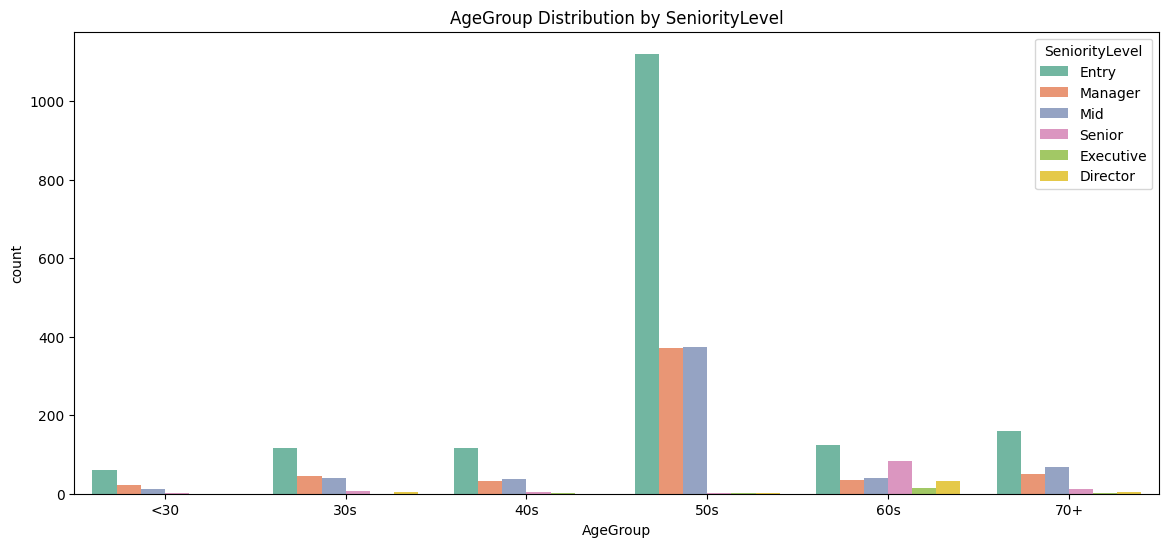


✅ Final AgeGroup Filling Summary:
FinalAgeGroup
50s    1870
60s     330
70+     294
30s     213
40s     195
<30      98
Name: count, dtype: int64

📁 Predicted AgeGroups for missing Age saved.


In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assume df is your full cleaned dataset with Age filled where available
# Step 1: Create AgeGroup for non-missing Age values
df['AgeGroup'] = pd.cut(df['Age'], 
                        bins=[0, 29, 39, 49, 59, 69, 120], 
                        labels=['<30', '30s', '40s', '50s', '60s', '70+'])

# Step 2: Correlation-style count plots
plt.figure(figsize=(14, 6))
sns.countplot(data=df[df['AgeGroup'].notna()], x='AgeGroup', hue='SeniorityLevel', palette='Set2')
plt.title("AgeGroup Distribution by SeniorityLevel")
plt.show()

plt.figure(figsize=(14, 6))
sns.countplot(data=df[df['AgeGroup'].notna()], x='AgeGroup', hue='JobFamily', palette='Set3')
plt.title("AgeGroup Distribution by JobFamily")
plt.xticks(rotation=45)
plt.show()

# Step 3: Group stats to base predictions on
agegroup_map = (
    df[df['AgeGroup'].notna()]
    .groupby(['SeniorityLevel', 'JobFamily'])['AgeGroup']
    .agg(lambda x: x.mode().iloc[0])  # Use most common AgeGroup per combo
    .reset_index()
    .rename(columns={'AgeGroup': 'PredictedAgeGroup'})
)

# Step 4: Merge prediction into original df
df = df.merge(agegroup_map, on=['SeniorityLevel', 'JobFamily'], how='left')

# Step 5: If AgeGroup is missing, use predicted value
df['FinalAgeGroup'] = df['AgeGroup']
df.loc[df['FinalAgeGroup'].isna(), 'FinalAgeGroup'] = df.loc[df['FinalAgeGroup'].isna(), 'PredictedAgeGroup']

# Check final status
print("\n✅ Final AgeGroup Filling Summary:")
print(df['FinalAgeGroup'].value_counts(dropna=False))

# Optional: Save predicted missing rows for review
missing_predicted = df[df['Age'].isna()][['EmpID', 'SeniorityLevel', 'JobFamily', 'PredictedAgeGroup']]
missing_predicted.to_csv("predicted_missing_agegroup.csv", index=False)
print("\n📁 Predicted AgeGroups for missing Age saved.")


In [8]:
import pandas as pd
from datetime import datetime
from dateutil.relativedelta import relativedelta

# Step 1: Map FinalAgeGroup to average age
agegroup_to_age = {
    '<30': 25,
    '30s': 35,
    '40s': 45,
    '50s': 55,
    '60s': 65,
    '70+': 75
}

# Step 2: Create column for Imputed Age
df['ImputedAge'] = df['FinalAgeGroup'].map(agegroup_to_age)

# Step 3: Fill missing Age with ImputedAge
df['Age'] = df['Age'].fillna(df['ImputedAge'])

# Step 4: Fill missing DOB using today's date minus imputed age
today = pd.to_datetime("today")

def calculate_dob(age):
    if pd.isna(age):
        return pd.NaT
    else:
        return today - relativedelta(years=int(age))

df['DOB'] = df['DOB'].fillna(df['Age'].apply(calculate_dob))

# Optional: Drop helper column if not needed
df.drop(columns=['ImputedAge'], inplace=True)

# Step 5: Check results
print("\n✅ Missing values after imputation:")
print("DOB missing:", df['DOB'].isna().sum())
print("Age missing:", df['Age'].isna().sum())



✅ Missing values after imputation:
DOB missing: 0
Age missing: 0


In [11]:
df['StartDate'] = pd.to_datetime(df['StartDate'], errors='coerce')


In [12]:
df['BirthYear'] = df['DOB'].dt.year


In [13]:
df['JoinYear'] = df['StartDate'].dt.year

# Assume AgeAtJoin = 25 as average starting age (tune this per job family if needed)
df['EstimatedBirthYear'] = df['JoinYear'] - 25

# Use if DOB missing
df['BirthYear'] = df['BirthYear'].fillna(df['EstimatedBirthYear'])


In [14]:
group_birthyear = df[~df['BirthYear'].isna()].groupby(['SeniorityLevel', 'JobFamily'])['BirthYear'].median().reset_index()
df = df.merge(group_birthyear, on=['SeniorityLevel', 'JobFamily'], how='left', suffixes=('', '_GroupMedian'))

# Use group-level median for missing BirthYear
df['BirthYear'] = df['BirthYear'].fillna(df['BirthYear_GroupMedian'])


In [15]:
current_year = pd.Timestamp.today().year
df['Age'] = current_year - df['BirthYear']


In [16]:
# Ensure DOB is in datetime format
df['DOB'] = pd.to_datetime(df['DOB'], errors='coerce')

# Filter only rows where both DOB and Age are available
valid_rows = df[df['DOB'].notna() & df['Age'].notna()]

# Calculate the year the dataset was likely created
valid_rows['EstimatedDatasetYear'] = valid_rows['DOB'].dt.year + valid_rows['Age'].astype(int)

# Show summary
estimated_year_mode = valid_rows['EstimatedDatasetYear'].mode().iloc[0]
estimated_year_mean = round(valid_rows['EstimatedDatasetYear'].mean(), 1)

print(f"📅 Most likely dataset year (mode): {estimated_year_mode}")
print(f"📊 Average estimated dataset year (mean): {estimated_year_mean}")


📅 Most likely dataset year (mode): 2025
📊 Average estimated dataset year (mean): 2025.0


In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(valid_rows['EstimatedDatasetYear'], bins=20, kde=True)
plt.title("Estimated Dataset Creation Year Distribution")
plt.xlabel("Year")
plt.ylabel("Frequency")
plt.show()


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Step 0: Load the dataset
file_path = r"D:\DATASCIENCE AND AI\ANALYTICS\internship\mark 5\cleaned dataset full\cleaned_mapped_employee_data.csv"
df = pd.read_csv(file_path)

# Step 1: Drop rows where Age is missing to compute correlations
df_age_known = df.dropna(subset=['Age'])

# Step 2: Encode categorical variables for correlation analysis
df_encoded = df_age_known.copy()
categorical_cols = df_encoded.select_dtypes(include='object').columns
df_encoded[categorical_cols] = df_encoded[categorical_cols].astype('category').apply(lambda x: x.cat.codes)

# Step 3: Compute correlation matrix and extract correlations with 'Age'
correlation_matrix = df_encoded.corr(numeric_only=True)
age_correlations = correlation_matrix['Age'].sort_values(ascending=False)

# Step 4: Compute group-wise median Age by JobFamily and SeniorityLevel
age_group_stats = df_age_known.groupby(['JobFamily', 'SeniorityLevel'])['Age'].median().reset_index()
age_group_stats.rename(columns={'Age': 'MedianAge'}, inplace=True)

# Step 5a: Visualization - Boxplot of Age by JobFamily and SeniorityLevel
plt.figure(figsize=(12, 7))
sns.boxplot(x='JobFamily', y='Age', hue='SeniorityLevel', data=df_age_known)
plt.xticks(rotation=45)
plt.title('Age Distribution by Job Family and Seniority Level')
plt.tight_layout()
plt.savefig('/mnt/data/age_boxplot.png')
plt.close()

# Step 5b: Visualization - Heatmap of Feature Correlation with Age
plt.figure(figsize=(8, 6))
sns.heatmap(df_encoded.corr(numeric_only=True)[['Age']].sort_values(by='Age', ascending=False), annot=True, cmap='coolwarm')
plt.title("Feature Correlation with Age")
plt.tight_layout()
plt.savefig('/mnt/data/age_correlation_heatmap.png')
plt.close()

# Step 6: Output results
age_correlations_top10 = age_correlations.head(10)
age_group_stats_sample = age_group_stats.head(10)

{
    "Top 10 Correlated Features with Age": age_correlations_top10,
    "Sample Median Age by JobFamily & SeniorityLevel": age_group_stats_sample,
    "Boxplot Path": "/mnt/data/age_boxplot.png",
    "Correlation Heatmap Path": "/mnt/data/age_correlation_heatmap.png"
}


{'Top 10 Correlated Features with Age': Age                           1.000000
 EmpID                         0.048853
 SeniorityLevel                0.038317
 GenderCode                    0.028213
 Supervisor                    0.027775
 EmployeeClassificationType    0.018401
 LocationCode                  0.016401
 Region                        0.011598
 Performance Score             0.009183
 DepartmentType                0.008786
 Name: Age, dtype: float64,
 'Sample Median Age by JobFamily & SeniorityLevel':                 JobFamily SeniorityLevel  MedianAge
 0         Admin & Support          Entry  52.889802
 1        Data & Analytics       Director  67.471595
 2        Data & Analytics          Entry  61.218344
 3        Data & Analytics            Mid  57.646817
 4        Data & Analytics         Senior  62.058864
 5  Executive & Leadership       Director  73.396304
 6  Executive & Leadership      Executive  59.471595
 7    Finance & Accounting          Entry  46.743326
 8   

In [3]:
# 📌 Part 1: Correlation Analysis with Age

import pandas as pd
import numpy as np

# Load the dataset
file_path = r"D:\DATASCIENCE AND AI\ANALYTICS\internship\mark 5\cleaned dataset full\cleaned_mapped_employee_data.csv"  # Update this path if needed
df = pd.read_csv(file_path)

# Drop rows with missing Age for correlation analysis
df_age_known = df.dropna(subset=['Age'])

# Encode categorical features
df_encoded = df_age_known.copy()
categorical_cols = df_encoded.select_dtypes(include='object').columns
df_encoded[categorical_cols] = df_encoded[categorical_cols].astype('category').apply(lambda x: x.cat.codes)

# Compute correlation matrix
correlation_matrix = df_encoded.corr(numeric_only=True)

# Extract and sort correlations with Age
age_correlations = correlation_matrix['Age'].sort_values(ascending=False)

# Print top 10 most correlated features with Age
top_10_corr = age_correlations.head(10)
print("🔍 Top 10 Features Correlated with Age:\n")
print(top_10_corr.to_frame(name='CorrelationWithAge'))


🔍 Top 10 Features Correlated with Age:

                            CorrelationWithAge
Age                                   1.000000
EmpID                                 0.048853
SeniorityLevel                        0.038317
GenderCode                            0.028213
Supervisor                            0.027775
EmployeeClassificationType            0.018401
LocationCode                          0.016401
Region                                0.011598
Performance Score                     0.009183
DepartmentType                        0.008786


In [4]:
# 📊 Part 2: Visualize Age Correlation as Heatmap

import seaborn as sns
import matplotlib.pyplot as plt

# Select top correlated features with Age for visualization
top_features = top_10_corr.index.tolist()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df_encoded[top_features].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("🔗 Correlation Heatmap of Top Features with Age")
plt.tight_layout()
plt.show()


C:\Users\alanm\AppData\Local\Temp\ipykernel_22336\703796707.py:13: UserWarning: Glyph 128279 (\N{LINK SYMBOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\alanm\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128279 (\N{LINK SYMBOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


In [3]:
import os
import pandas as pd

# Load the dataset
file_path = r"D:\DATASCIENCE AND AI\ANALYTICS\internship\mark 5\cleaned dataset full\cleaned_mapped_employee_data.csv"
df = pd.read_csv(file_path)

# Convert DOB to datetime and extract only the year into the same column
df['DOB'] = pd.to_datetime(df['DOB'], errors='coerce').dt.year.astype('Int64')  # Use Int64 to allow NaNs

# Save the modified dataset
output_dir = r"D:\DATASCIENCE AND AI\ANALYTICS\internship\mark 5\cleaned dataset full"
os.makedirs(output_dir, exist_ok=True)
output_path = os.path.join(output_dir, "cleaned1.csv")
df.to_csv(output_path, index=False)

# Show the first 10 rows of the updated data
print(df[['EmpID', 'DOB', 'Age', 'SeniorityLevel', 'JobFamily']].head(10))


   EmpID   DOB        Age SeniorityLevel   JobFamily
0   3427  1969  55.731691          Entry  Production
1   3428  <NA>        NaN          Entry  Production
2   3429  1991  33.735797        Manager       Sales
3   3430  1998  27.241615        Manager       Sales
4   3431  <NA>        NaN        Manager       Sales
5   3432  1949  76.243669        Manager       Sales
6   3433  1942  83.000684        Manager       Sales
7   3434  1957  68.317591        Manager       Sales
8   3435  <NA>        NaN        Manager       Sales
9   3436  1949  75.635866        Manager       Sales


In [5]:
import pandas as pd
import numpy as np

# Load your dataset
file_path = r"D:\DATASCIENCE AND AI\ANALYTICS\internship\mark 5\cleaned dataset full\cleaned1.csv"
df = pd.read_csv(file_path)

# Convert DOB to year only
df['DOB'] = pd.to_datetime(df['DOB'], errors='coerce').dt.year
df['StartDate'] = pd.to_datetime(df['StartDate'], errors='coerce')
df['StartYear'] = df['StartDate'].dt.year

# 1. Group-wise mean Age
age_known = df.dropna(subset=['Age'])
grouped_stats = (
    age_known.groupby(['JobFamily', 'SeniorityLevel'])['Age']
    .agg(['mean', 'count'])
    .reset_index()
    .rename(columns={'mean': 'GroupMeanAge', 'count': 'SampleCount'})
)

# Merge back
df = df.merge(grouped_stats, on=['JobFamily', 'SeniorityLevel'], how='left')

# 2. Impute Age with jitter
np.random.seed(42)
age_missing = df['Age'].isna()
df.loc[age_missing, 'Age'] = df.loc[age_missing, 'GroupMeanAge'] + np.random.uniform(-2, 2, size=age_missing.sum())

# 3. Estimate missing DOB using CurrentYear - Age
current_year = pd.Timestamp.now().year
dob_missing = df['DOB'].isna() & df['Age'].notna()
df['Estimated_DOB_Year'] = df['DOB']
df.loc[dob_missing, 'Estimated_DOB_Year'] = (current_year - df.loc[dob_missing, 'Age']).round().astype('Int64')

# 4. Replace missing DOBs with estimated DOBs
df['DOB'] = df['DOB'].fillna(df['Estimated_DOB_Year'])

# 5. Drop temporary columns
df.drop(columns=['Age_Imputed', 'DOB_Imputed', 'Estimated_DOB_Year'], errors='ignore', inplace=True)

# 6. Ensure DOB is stored as integer year
df['DOB'] = df['DOB'].astype('Int64')

# 7. Save the cleaned dataset
output_path = r"D:\DATASCIENCE AND AI\ANALYTICS\internship\mark 5\cleaned dataset full\cleaned2.csv"
df.to_csv(output_path, index=False)

# 8. Show sample output
print(df[['EmpID', 'Age', 'DOB', 'SeniorityLevel', 'JobFamily']].head(10))


   EmpID        Age   DOB SeniorityLevel   JobFamily
0   3427  55.731691  1970          Entry  Production
1   3428  53.062344  1972          Entry  Production
2   3429  33.735797  1970        Manager       Sales
3   3430  27.241615  1970        Manager       Sales
4   3431  55.686063  1969        Manager       Sales
5   3432  76.243669  1970        Manager       Sales
6   3433  83.000684  1970        Manager       Sales
7   3434  68.317591  1970        Manager       Sales
8   3435  54.811182  1970        Manager       Sales
9   3436  75.635866  1970        Manager       Sales


In [7]:
# Summary stats grouped by Seniority Level and JobFamily
summary = df.groupby(['SeniorityLevel', 'JobFamily'])[['Age', 'DOB']].agg(['mean', 'min', 'max', 'count'])
print(summary)


                                                   Age                        \
                                                  mean        min        max   
SeniorityLevel JobFamily                                                       
Director       Data & Analytics              59.163068  36.383299  74.647502   
               Executive & Leadership        65.091916  29.976728  77.971253   
               IT & Infrastructure           62.338328  54.811773  67.808350   
               Sales                         32.252909  29.056810  37.166324   
Entry          Admin & Support               52.496208  24.331280  82.973306   
               Data & Analytics              55.026868  24.487337  82.412047   
               Finance & Accounting          48.428264  27.323751  72.158795   
               IT & Infrastructure           51.921910  24.221766  80.731006   
               Other                         53.651081  26.069815  81.831622   
               Production               

C:\Users\alanm\AppData\Local\Temp\ipykernel_19760\3456947989.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=seniority_age.index, y=seniority_age.values, palette="coolwarm")


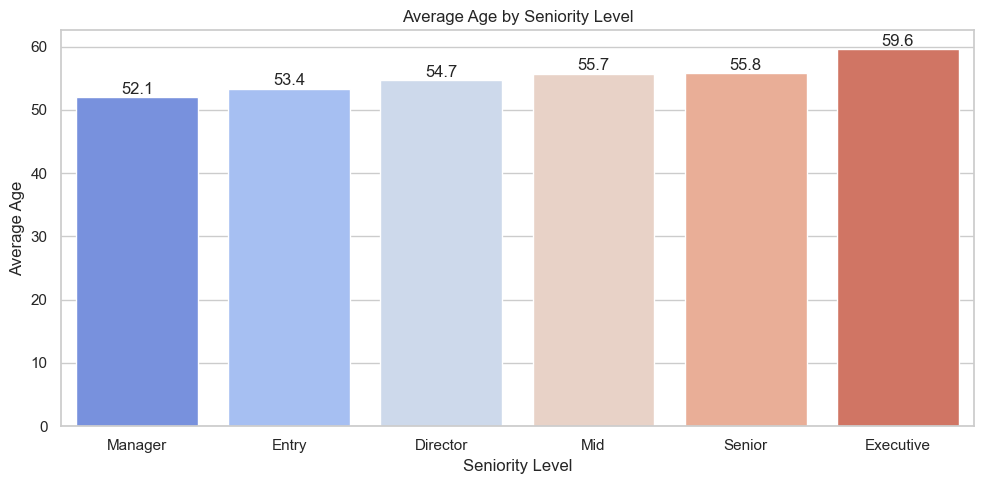

C:\Users\alanm\AppData\Local\Temp\ipykernel_19760\3456947989.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=jobfamily_age.index, y=jobfamily_age.values, palette="Set2")


C:\Users\alanm\AppData\Local\Temp\ipykernel_19760\3456947989.py:42: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set visual theme
sns.set(style="whitegrid")

# 1️⃣ Average Age by Seniority Level
plt.figure(figsize=(10, 5))
seniority_age = df.groupby('SeniorityLevel')['Age'].mean().sort_values()
sns.barplot(x=seniority_age.index, y=seniority_age.values, palette="coolwarm")
plt.title("Average Age by Seniority Level")
plt.xlabel("Seniority Level")
plt.ylabel("Average Age")
for index, value in enumerate(seniority_age.values):
    plt.text(index, value + 0.5, f"{value:.1f}", ha='center')
plt.tight_layout()
plt.show()

# 2️⃣ Average Age by Job Family
plt.figure(figsize=(12, 6))
jobfamily_age = df.groupby('JobFamily')['Age'].mean().sort_values()
sns.barplot(x=jobfamily_age.index, y=jobfamily_age.values, palette="Set2")
plt.title("Average Age by Job Family")
plt.xlabel("Job Family")
plt.ylabel("Average Age")
plt.xticks(rotation=45)
for index, value in enumerate(jobfamily_age.values):
    plt.text(index, value + 0.5, f"{value:.1f}", ha='center')
plt.tight_layout()
plt.show()

# 3️⃣ Average Birth Year by Employee Rating
if 'Current Employee Rating' in df.columns:
    plt.figure(figsize=(10, 5))
    rating_dob = df.groupby('Current Employee Rating')['DOB'].mean().sort_index()
    sns.lineplot(x=rating_dob.index, y=rating_dob.values, marker='o', color='green')
    plt.title("Average Birth Year by Employee Rating")
    plt.xlabel("Employee Rating")
    plt.ylabel("Average Birth Year")
    for i, val in enumerate(rating_dob.values):
        plt.text(rating_dob.index[i], val + 0.5, f"{int(val)}", ha='center')
    plt.tight_layout()
    plt.show()


C:\Users\alanm\AppData\Local\Temp\ipykernel_19760\3759999280.py:13: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(known_age, label="Original Ages", shade=True, linewidth=2)
C:\Users\alanm\AppData\Local\Temp\ipykernel_19760\3759999280.py:14: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(imputed_age, label="Imputed Ages", shade=True, linewidth=2, linestyle="--")


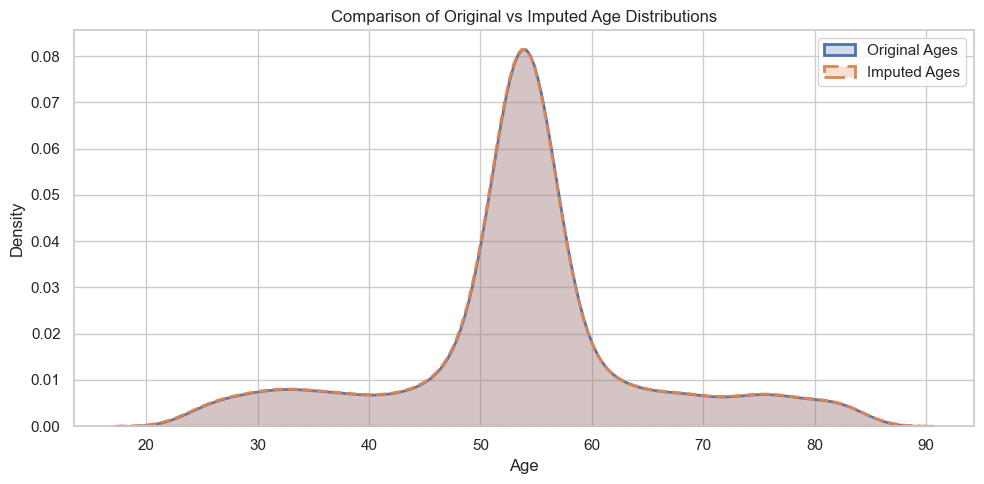

In [12]:
import matplotlib.pyplot as plt

# Split known and imputed
known_age = df[~df['EmpID'].isin(df[df['Age'].isna()].EmpID)]['Age']
imputed_age = df[df['Age'].isna() == False & df['EmpID'].duplicated(keep=False)]['Age']

# Optional: If you tracked imputation in a flag like df['Age_Imputed'], use that instead:
# known_age = df[df['Age_Imputed'] == False]['Age']
# imputed_age = df[df['Age_Imputed'] == True]['Age']

# Plot KDE comparison
plt.figure(figsize=(10, 5))
sns.kdeplot(known_age, label="Original Ages", shade=True, linewidth=2)
sns.kdeplot(imputed_age, label="Imputed Ages", shade=True, linewidth=2, linestyle="--")
plt.title("Comparison of Original vs Imputed Age Distributions")
plt.xlabel("Age")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd

# Load the final cleaned dataset
df = pd.read_csv(r"D:\DATASCIENCE AND AI\ANALYTICS\internship\mark 5\cleaned dataset full\cleaned2.csv")  # Replace with your actual path

# 1. Check missing values
missing_summary = df.isnull().sum().sort_values(ascending=False)
missing_percent = (df.isnull().mean() * 100).sort_values(ascending=False)

# 2. Dataset shape and structure
print("Dataset shape:", df.shape)
print("\nMissing Values Summary:\n", missing_summary[missing_summary > 0])
print("\nMissing Percentages:\n", missing_percent[missing_percent > 0])
print("\nColumn Data Types:\n", df.dtypes)


Dataset shape: (3000, 30)

Missing Values Summary:
 ExitDate                  1467
TerminationDescription    1467
dtype: int64

Missing Percentages:
 ExitDate                  48.9
TerminationDescription    48.9
dtype: float64

Column Data Types:
 EmpID                           int64
StartDate                      object
ExitDate                       object
JobFamily                      object
Supervisor                     object
BusinessUnit                   object
EmployeeStatus                 object
EmployeeType                   object
PayZone                        object
EmployeeClassificationType     object
TerminationType                object
TerminationDescription         object
DepartmentType                 object
DivisionGroup                  object
DOB                             int64
Region                         object
JobFunctionGroup               object
GenderCode                     object
LocationCode                    int64
RaceDesc                      

In [20]:
import pandas as pd
import os
from datetime import datetime

# 🔹 Load your cleaned dataset
file_path = r"D:\DATASCIENCE AND AI\ANALYTICS\internship\mark 5\cleaned dataset full\cleaned2.csv"
df = pd.read_csv(file_path)

# 🔹 Convert StartDate and ExitDate to datetime (keep full datetime64 format)
df['StartDate'] = pd.to_datetime(df['StartDate'], errors='coerce')
df['ExitDate'] = pd.to_datetime(df['ExitDate'], errors='coerce')

# 🔹 Fill missing ExitDate with 'Present' and TerminationDescription with 'Active'
df['ExitDate'] = df['ExitDate'].fillna("Present")
df['TerminationDescription'] = df['TerminationDescription'].fillna("Active")

# 🔹 Calculate tenure
current_date = pd.to_datetime("today").normalize()  # removes time, keeps datetime format
df['EffectiveExit'] = df['ExitDate'].apply(lambda x: current_date if x == "Present" else x)
df['TenureDays'] = (df['EffectiveExit'] - df['StartDate']).dt.days

# 🔹 Drop intermediate and unnecessary columns
columns_to_drop = ['StartYear', 'GroupMeanAge', 'SampleCount', 'TenureMonths']
df.drop(columns=[col for col in columns_to_drop if col in df.columns], inplace=True)
df.drop(columns=['EffectiveExit'], inplace=True)

# 🔹 Format StartDate and ExitDate as YYYY-MM-DD strings
df['StartDate'] = df['StartDate'].dt.strftime('%Y-%m-%d')
df['ExitDate'] = df['ExitDate'].apply(lambda x: x if x == "Present" else pd.to_datetime(x).strftime('%Y-%m-%d'))

# 🔹 Save the updated file
output_dir = r"D:\DATASCIENCE AND AI\ANALYTICS\internship\mark 5\cleaned dataset full"
os.makedirs(output_dir, exist_ok=True)
output_path = os.path.join(output_dir, "cleaned3.csv")
df.to_csv(output_path, index=False)

# 🔹 Show preview
print("✅ File saved to:", output_path)
print("\n🔍 Preview of updated data:")
print(df[['EmpID', 'StartDate', 'ExitDate', 'TerminationDescription']].head(10))




✅ File saved to: D:\DATASCIENCE AND AI\ANALYTICS\internship\mark 5\cleaned dataset full\cleaned3.csv

🔍 Preview of updated data:
   EmpID   StartDate    ExitDate                 TerminationDescription
0   3427  2019-09-20     Present                                 Active
1   3428  2023-02-11     Present                                 Active
2   3429  2018-12-10     Present                                 Active
3   3430  2021-06-21     Present                                 Active
4   3431  2019-06-29     Present                                 Active
5   3432  2020-01-17     Present                                 Active
6   3433  2022-04-06  2023-07-03  Me see picture nature degree benefit.
7   3434  2020-11-06  2023-01-29       Blue community type skill story.
8   3435  2018-08-18     Present                                 Active
9   3436  2022-01-21  2023-06-29                   Summer personal bag.


In [21]:
import pandas as pd

# Load the final cleaned dataset
df = pd.read_csv(r"D:\DATASCIENCE AND AI\ANALYTICS\internship\mark 5\cleaned dataset full\cleaned3.csv")  # Replace with your actual path

# 1. Check missing values
missing_summary = df.isnull().sum().sort_values(ascending=False)
missing_percent = (df.isnull().mean() * 100).sort_values(ascending=False)

# 2. Dataset shape and structure
print("Dataset shape:", df.shape)
print("\nMissing Values Summary:\n", missing_summary[missing_summary > 0])
print("\nMissing Percentages:\n", missing_percent[missing_percent > 0])
print("\nColumn Data Types:\n", df.dtypes)

Dataset shape: (3000, 27)

Missing Values Summary:
 Series([], dtype: int64)

Missing Percentages:
 Series([], dtype: float64)

Column Data Types:
 EmpID                           int64
StartDate                      object
ExitDate                       object
JobFamily                      object
Supervisor                     object
BusinessUnit                   object
EmployeeStatus                 object
EmployeeType                   object
PayZone                        object
EmployeeClassificationType     object
TerminationType                object
TerminationDescription         object
DepartmentType                 object
DivisionGroup                  object
DOB                             int64
Region                         object
JobFunctionGroup               object
GenderCode                     object
LocationCode                    int64
RaceDesc                       object
MaritalDesc                    object
Performance Score              object
Current Employee